In [1]:
import os
import time as timer

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import numpy as np

from sklearn.preprocessing import MinMaxScaler

from torchvision import datasets
import torchvision.transforms as T

import visualization_utils as vu
import train_utils as tu
import autoencoder as ae
###

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Define Constants

In [2]:
DATA_DIR = './data'
MODEL_DIR = './models'

EPOCHS = 100
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
dz = 300

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## Load Fashion MNIST Dataset

In [3]:
training_data = datasets.FashionMNIST(
    root=DATA_DIR,
    train=True, 
    download=True, 
    transform=T.ToTensor()
)

test_data = datasets.FashionMNIST(
    root=DATA_DIR,
    train=False, 
    download=True, 
    transform=T.ToTensor()
)

In [4]:
"""Create data loaders"""
train_dl = DataLoader(training_data, batch_size=BATCH_SIZE)
test_dl = DataLoader(test_data, batch_size=BATCH_SIZE)

In [5]:
X_train = training_data.data
X_test = test_data.data

[n, dx1, dx2] = X_train.shape
n, dx1, dx2

(60000, 28, 28)

### Reshape Train and Test Data

In [6]:
X_train_reshaped = torch.reshape(X_train, (-1, dx1*dx2)).float()
X_test_reshaped = torch.reshape(X_test, (-1, dx1*dx2)).float()

X_train_reshaped.shape, X_test_reshaped.shape

(torch.Size([60000, 784]), torch.Size([10000, 784]))

### Scale using MinMaxScaler

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_train_scaled.shape

(60000, 784)

In [10]:
X_test_scaled = scaler.fit_transform(X_test_reshaped)
X_test_scaled.shape

(10000, 784)

## Reconstruct Decoded

In [8]:
"""Load trained autoencoder"""
print(f"Using {DEVICE} device")

# Define model
model = ae.MLPAutoEnc(d_in=dx1*dx2, d_z=dz, d_h=512).to(DEVICE)

model_path = os.path.join(MODEL_DIR, "mlpae_sigm_ep100_fmnist.pth")
model.load_state_dict(torch.load(model_path))
model.eval()

print(model)

Using cuda device
MLPAutoEnc(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=300, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=300, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


In [16]:
"""From Numpy to Tensor"""
X_train_scaled = torch.tensor(X_train_scaled).float().to(DEVICE)
X_test_scaled = torch.tensor(X_test_scaled).float().to(DEVICE)
X_train_scaled.shape, X_test_scaled.shape

C:\Users\USER\AppData\Local\Temp\ipykernel_14844\719836992.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_scaled = torch.tensor(X_train_scaled).float().to(DEVICE)
C:\Users\USER\AppData\Local\Temp\ipykernel_14844\719836992.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_scaled = torch.tensor(X_test_scaled).float().to(DEVICE)


(torch.Size([60000, 784]), torch.Size([10000, 784]))

In [17]:
X_train_recons = model(X_train_scaled)
X_test_recons = model(X_test_scaled)
X_train_recons.shape, X_test_recons.shape

(torch.Size([60000, 784]), torch.Size([10000, 784]))

### Visualize Reconstructed Training Data

img_np : 0.0 1.0


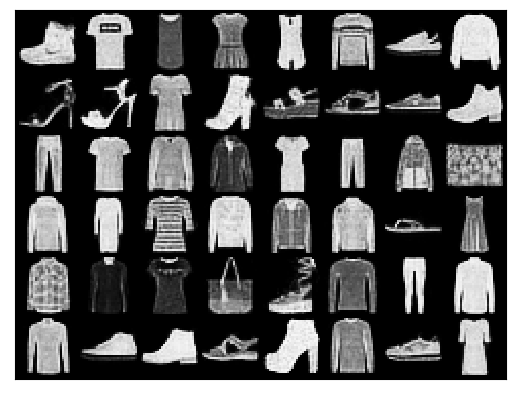

In [20]:
viz = torch.reshape(X_train_recons.to('cpu'), (-1, dx1, dx2))
grid = vu.set_grid(viz, num_cells=48)
vu.show(grid)

### Visualize Reconstructed Test Data

img_np : 0.0 1.0


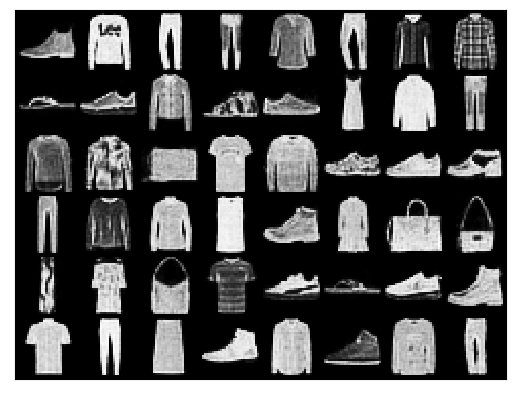

In [21]:
viz = torch.reshape(X_test_recons.to('cpu'), (-1, dx1, dx2))
grid = vu.set_grid(viz, num_cells=48)
vu.show(grid)

In [22]:
train_rec_loss = torch.mean(torch.sqrt(torch.sum((X_train_scaled.to('cpu') - X_train_recons.to('cpu'))**2, 1)))
test_rec_loss = torch.mean(torch.sqrt(torch.sum((X_test_scaled.to('cpu') - X_test_recons.to('cpu'))**2, 1)))

print(f"Train reconstruction loss: {train_rec_loss:>.2f}")
print(f"Test reconstruction loss: {test_rec_loss:>.2f}")

Train reconstruction loss: 1.11
Test reconstruction loss: 1.18
